### Covid-19 Fake or Fact Analysis with NLP Classifiers
> During the COVID-19 pandamic, social media saw a significant increase in the spread of false information. It caused undue harm including fatalities around the world. Machine Learning Models using Natural Language Processing (NLP) provide a mechanism to validate information during such emergencies, which could save lives.

> The project uses NLP Classifiers: Linear Regression, Decision Tree, SVM and Multinomial NB to classify Covid-19 news as fake or real. It uses the kaggle dataset: https://www.kaggle.com/datasets/elvinagammed/covid19-fake-news-dataset-nlp for model training and evaluation.

> The dataset consists of 9600 messages from various social media platforms namely: Twitter, Facebook, Instagram etc.


#### Import necessary libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.svm import SVC

In [5]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from nltk import TweetTokenizer
import time

In [6]:
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('punkt')
#nltk.download('stopwords')

In [7]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

In [8]:
import random
random.seed(42)

#### Read training, test data. Drop duplicates and null values
> Note: Data is provided as train and test set.  So splitting was performed.

In [10]:
df_train = pd.read_csv('data/train.csv', on_bad_lines='warn').drop_duplicates().dropna()
df_test = pd.read_csv('data/test.csv').drop_duplicates().dropna()

### EDA
> #### Sample few messages

In [12]:
df_train.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6420 entries, 0 to 6419
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6420 non-null   int64 
 1   tweet   6420 non-null   object
 2   label   6420 non-null   object
dtypes: int64(1), object(2)
memory usage: 150.6+ KB


In [14]:
df_test.head()

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real


#### Findings: 
> Need to remove punctuation, hashtags, usernames and numbers

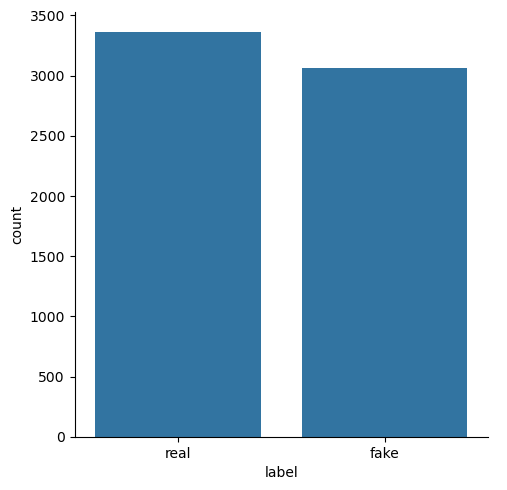

In [16]:
sns.catplot(data=df_train, kind='count', x='label')

#### Findings: Dataset is balanced. About 3000 per class in training set

<Axes: >

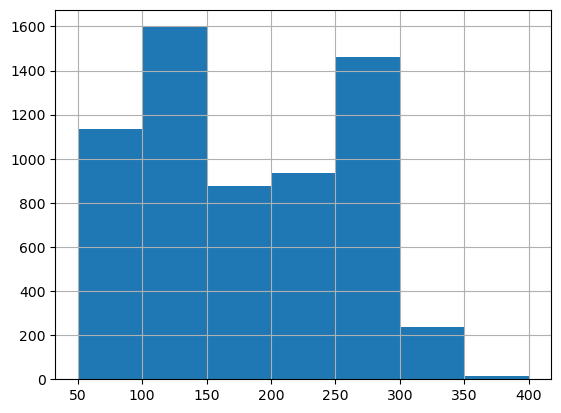

In [18]:
df_train['tweet'].str.len().hist(bins=[50,100,150,200,250,300,350,400])

#### Findings: Most messages have 100-150 or 250-300 words

In [20]:
def get_top_ngram(doc, n, c):
    vect = CountVectorizer(ngram_range=(n, n)).fit(doc)
    bag_of_words = vect.transform(doc)
    tot_words = bag_of_words.sum(axis=0)
    words_freq = [(word, tot_words[0, i])
                  for word, i in vect.vocabulary_.items()]
    return sorted(words_freq, key = lambda x: x[1], reverse=True)[:c]

<Axes: >

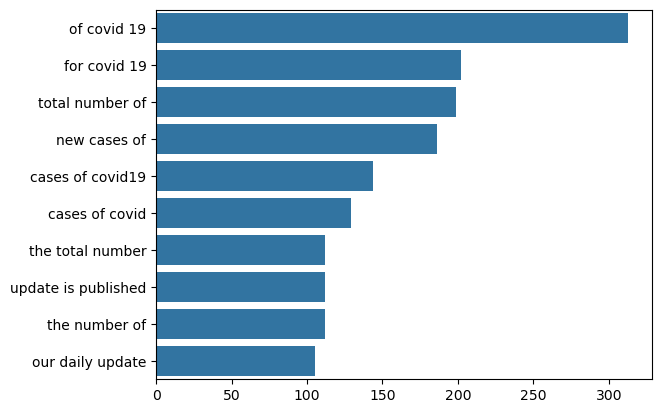

In [21]:
top_3_grams=get_top_ngram(df_train['tweet'],n=3, c=10)
x,y=map(list,zip(*top_3_grams))
sns.barplot(x=y,y=x)

#### Findings: 3 word combinations talk mostly about number of covid cases

<Axes: >

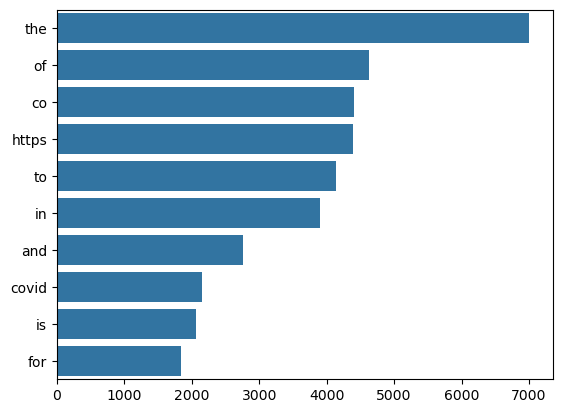

In [23]:
top_1_word=get_top_ngram(df_train['tweet'],n=1, c=10)
x,y=map(list,zip(*top_1_word))
sns.barplot(x=y,y=x)

#### Findings: 1000s of stop words across messages, that need to be removed

In [25]:
def plotWords():
    plt.figure(figsize = (10,10)) 
    wc = WordCloud(max_words = 500,background_color='gray', stopwords = STOPWORDS).generate(" ".join(df_train['tweet']))
    plt.imshow(wc , interpolation = 'bilinear')
    plt.axis("off")
    plt.show()

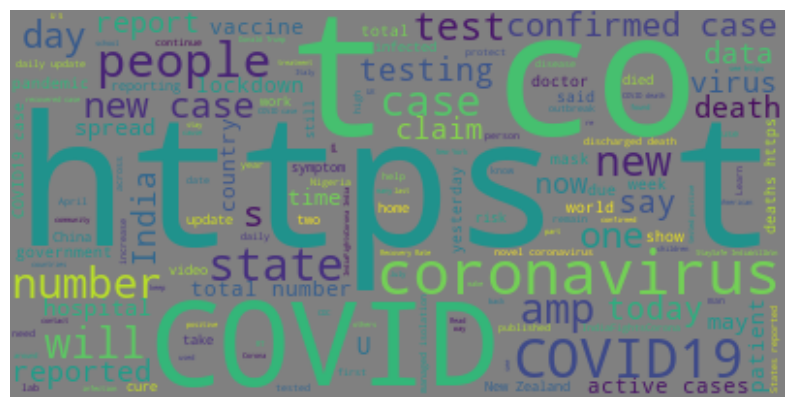

In [26]:
plotWords()

#### Findings: Word cloud shows lot of irrelevant words http, t.co 

### Data Preprocessing
> Remove usernames, http urls, punctuation, numerals.
> Lemmatize or word stem (Optional)

In [29]:
import re

In [30]:
def cleanTweet(text):
    text = text.lower()
    text = re.sub(r"@\w+", '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'[0-9]', '', text)
    #text = WordNetLemmatizer().lemmatize(text)
    #text = PorterStemmer().stem(text)
    return text

In [31]:
def tweetPreprocess(tweet):
    tweet =  ' '.join([cleanTweet(w) for w in TweetTokenizer().tokenize(tweet)])
    tweet =  ' '.join([word for word in tweet.split() if word not in stopwords.words('english')])
    return tweet

In [32]:
df_train['tweet'] = df_train['tweet'].apply(tweetPreprocess)
df_test['tweet'] = df_test['tweet'].apply(tweetPreprocess)

<Axes: >

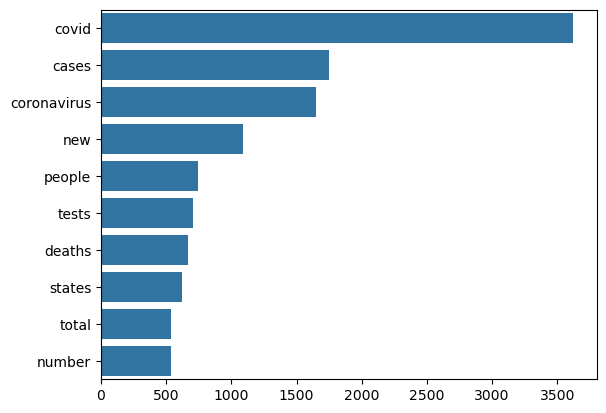

In [33]:
top_1_word=get_top_ngram(df_train['tweet'],n=1, c=10)
x,y=map(list,zip(*top_1_word))
sns.barplot(x=y,y=x)

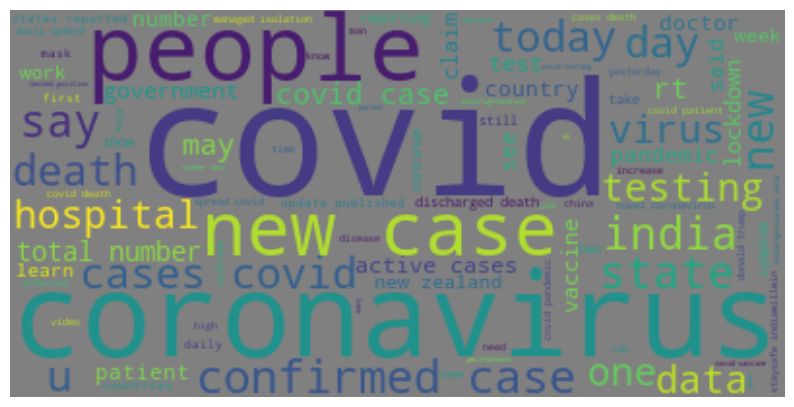

In [34]:
plotWords()

<Axes: >

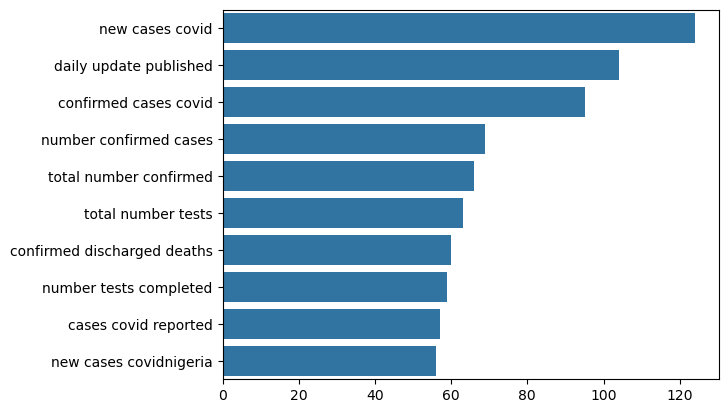

In [35]:
top_3_grams=get_top_ngram(df_train['tweet'],n=3, c=10)
x,y=map(list,zip(*top_3_grams))
sns.barplot(x=y,y=x)

#### Findings: Cleaning messages indicates relevant words to Covid-19 from word cloud, ngrams

### NLP Classifer Model Training and Evaulation
> Linear Regression, DecisionTree, MultinomialNB and SVM models are evaluated.   
> CountVectorizer and TDIDF text processing techniques are used.
> Hyperparameters are set for each model and GridSearched for best model.

In [38]:
X_train=df_train['tweet']
y_train=df_train['label']
X_test=df_test['tweet']
y_test=df_test['label']

In [39]:
X_train.head()

0    cdc currently reports deaths general discrepan...
1    states reported deaths small rise last tuesday...
2    politically correct woman almost uses pandemic...
3    indiafightscorona covid testing laboratories i...
4    populous states generate large case counts loo...
Name: tweet, dtype: object

In [40]:
y_test.head()

0    fake
1    fake
2    fake
3    fake
4    real
Name: label, dtype: object

In [41]:
res = pd.DataFrame(columns=['Train Accuracy', 'Test Accuracy', 'Execution Time(s)'])

In [42]:
estimators = []

#### Implementation:
> Define a function to perform grid search, draw confusion matrix.
> Train all the models, peforming Grid Search with hyperparameters.
> Compile the results and models in dataframes for post analysis.

In [44]:
def grid_search(desc, model, vect, params):
    pipe = Pipeline( [('vect', vect), ('clf', model)] )
    s = time.time()
    grid = GridSearchCV(pipe, param_grid=params)
    grid.fit(X_train, y_train)
    e = time.time()
    test_acc = grid.score(X_test, y_test)
    train_acc = grid.score(X_train, y_train)
    res.loc[desc] = [train_acc, test_acc, e-s]
    print(f'Results: {res.loc[desc]}')
    print(f'Best Parameters: {grid.best_params_}')
    estimators.append([desc, grid.best_estimator_])
    return grid
    

In [45]:
def drawConfMat(conf, title):
    ax= plt.subplot()
    sns.heatmap(conf, annot=True, fmt="d", ax=ax, cbar=False)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    plt.title(title)
    ax.xaxis.set_ticklabels(['fake', 'real']); ax.yaxis.set_ticklabels(['fake', 'real']);

In [46]:
grid = grid_search("LR with CV", LogisticRegression(), CountVectorizer(), 
                {
                    'clf__penalty':['l2'],
                    'clf__C' : [1],
                    'clf__max_iter'  : [100, 200],
                    'vect__max_features': [5000, 10000, 20000],   
                    'vect__stop_words': ['english', None]
                }
           )



Results: Train Accuracy       0.987539
Test Accuracy        0.921028
Execution Time(s)    8.546452
Name: LR with CV, dtype: float64
Best Parameters: {'clf__C': 1, 'clf__max_iter': 100, 'clf__penalty': 'l2', 'vect__max_features': 10000, 'vect__stop_words': None}


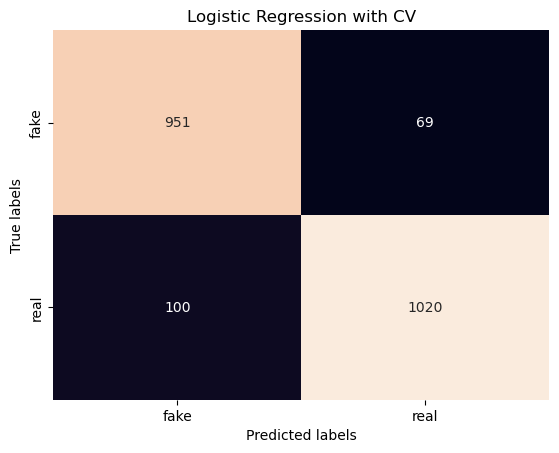

In [47]:
drawConfMat(confusion_matrix(y_test, grid.predict(X_test)), "Logistic Regression with CV")

In [48]:
grid = grid_search("MNB with CV", MultinomialNB(), CountVectorizer(), 
                    {
                        'vect__max_features': [10000, 20000],
                        'vect__stop_words': [None],
                        'clf__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000] 
                    }
                  )


Results: Train Accuracy       0.966978
Test Accuracy        0.908411
Execution Time(s)    8.245466
Name: MNB with CV, dtype: float64
Best Parameters: {'clf__alpha': 0.1, 'vect__max_features': 20000, 'vect__stop_words': None}


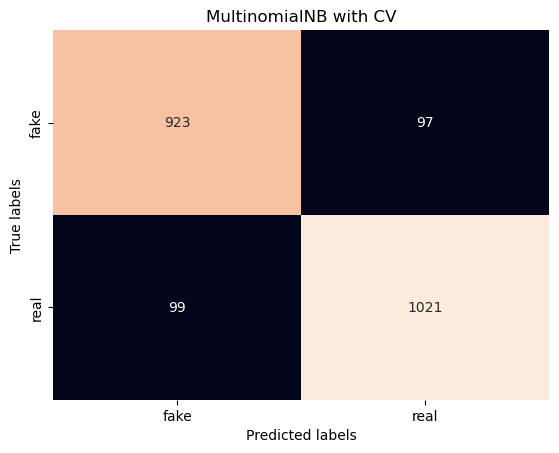

In [49]:
drawConfMat(confusion_matrix(y_test, grid.predict(X_test)), "MultinomialNB with CV")

In [50]:
grid = grid_search("DTree with CV", DecisionTreeClassifier(), CountVectorizer(), 
            {
                'vect__max_features': [2000,5000,10000],
                'vect__stop_words': [None],
                'clf__max_depth': [100],
                'clf__min_samples_split': [2],
                'clf__min_samples_leaf': [2]
            }
         )


Results: Train Accuracy       0.946417
Test Accuracy        0.832243
Execution Time(s)    6.050590
Name: DTree with CV, dtype: float64
Best Parameters: {'clf__max_depth': 100, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'vect__max_features': 10000, 'vect__stop_words': None}


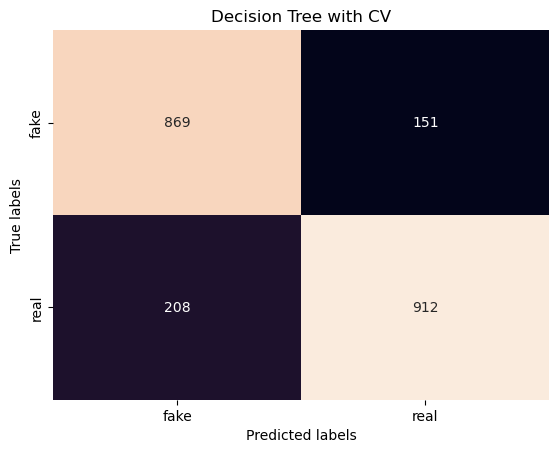

In [51]:
drawConfMat(confusion_matrix(y_test, grid.predict(X_test)), "Decision Tree with CV")

In [52]:
grid = grid_search("SVM with CV", SVC(), CountVectorizer(), 
                       {
                        'vect__max_features': [5000],
                        'vect__stop_words': [None],
                        'clf__C': [1000],  
                        'clf__gamma': [0.0001, 0.00001], 
                        'clf__kernel': ['rbf']
                       }
                  )

Results: Train Accuracy        0.975078
Test Accuracy         0.913084
Execution Time(s)    18.590330
Name: SVM with CV, dtype: float64
Best Parameters: {'clf__C': 1000, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf', 'vect__max_features': 5000, 'vect__stop_words': None}


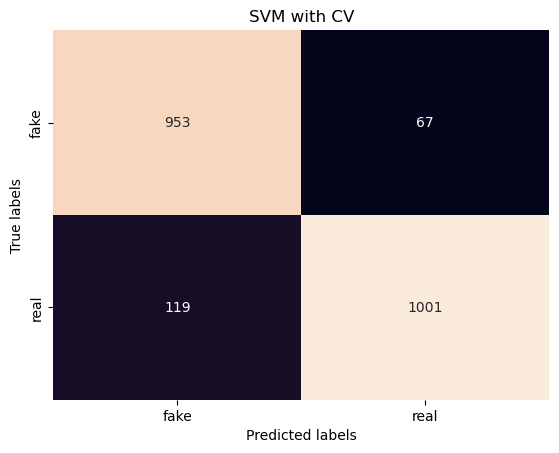

In [53]:
drawConfMat(confusion_matrix(y_test, grid.predict(X_test)), "SVM with CV")

In [54]:
grid = grid_search("LR with TDIDF", LogisticRegression(), TfidfVectorizer(), 
                   {
                        'vect__max_df': (0.5, 0.75, 1.0),
                        'vect__max_features': [5000],
                        'vect__ngram_range': ((1, 1), (1, 2), (1,3)),    
                        'clf__penalty':['l2'],
                        'clf__C' : [1],
                        'clf__max_iter'  : [100, 200]
                   }
                  )
                   

Results: Train Accuracy        0.950623
Test Accuracy         0.908879
Execution Time(s)    22.672263
Name: LR with TDIDF, dtype: float64
Best Parameters: {'clf__C': 1, 'clf__max_iter': 100, 'clf__penalty': 'l2', 'vect__max_df': 0.5, 'vect__max_features': 5000, 'vect__ngram_range': (1, 2)}


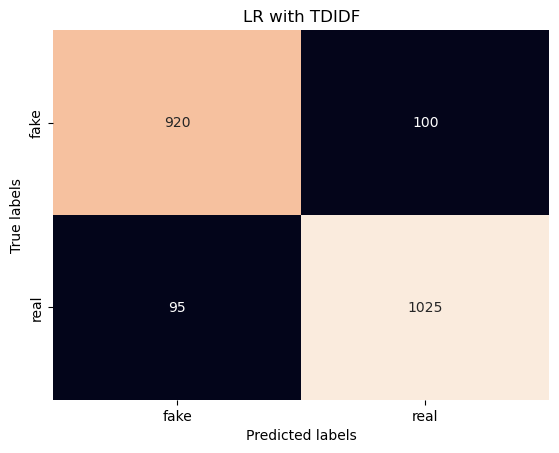

In [55]:
drawConfMat(confusion_matrix(y_test, grid.predict(X_test)), "LR with TDIDF")

In [56]:
grid = grid_search("MNB with TDIDF", MultinomialNB(), TfidfVectorizer(), 
                    {
                        'vect__max_features': [50000], 
                        'vect__max_df': [0.5],
                        'vect__ngram_range': [(1, 2), (1,3)],    
                        'clf__alpha': [.1, 1]
                    }
                  )

Results: Train Accuracy       0.997352
Test Accuracy        0.925234
Execution Time(s)    6.763815
Name: MNB with TDIDF, dtype: float64
Best Parameters: {'clf__alpha': 0.1, 'vect__max_df': 0.5, 'vect__max_features': 50000, 'vect__ngram_range': (1, 2)}


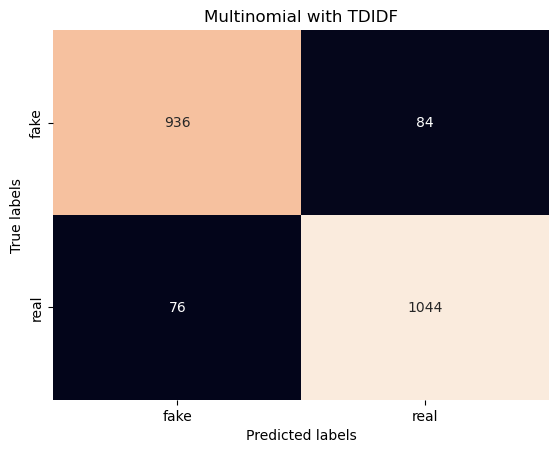

In [57]:
drawConfMat(confusion_matrix(y_test, grid.predict(X_test)), "Multinomial with TDIDF")

In [58]:
grid = grid_search("SVM with TDIDF", SVC(), TfidfVectorizer(), 
                       {
                        'vect__max_features': [5000], 
                        'vect__max_df': [0.5],
                        'vect__ngram_range': [(1, 2), (1,3)],   
                        'clf__C': [1000],  
                        'clf__gamma': [0.0001, 0.00001], 
                        'clf__kernel': ['rbf']
                       }
                  )

Results: Train Accuracy        0.940187
Test Accuracy         0.910748
Execution Time(s)    64.438284
Name: SVM with TDIDF, dtype: float64
Best Parameters: {'clf__C': 1000, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf', 'vect__max_df': 0.5, 'vect__max_features': 5000, 'vect__ngram_range': (1, 2)}


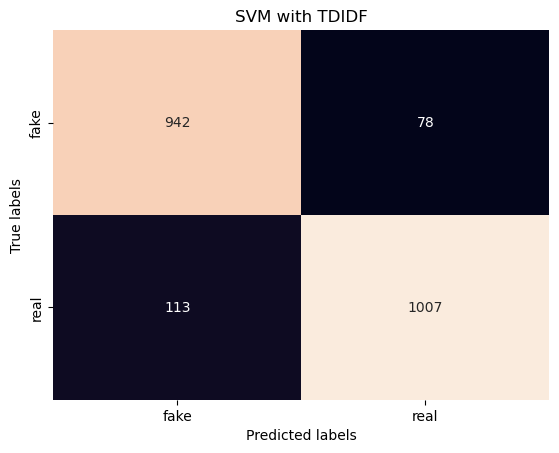

In [59]:
drawConfMat(confusion_matrix(y_test, grid.predict(X_test)), "SVM with TDIDF")

### Optimizing for minimizing false negatives
>  Tune the alpha hyperparameter to minimize false negatives with Naive Bayes Model
>  for deployment

In [61]:
grid = grid_search("Tuned MNB with TDIDF", MultinomialNB(), TfidfVectorizer(), 
                    {
                        'vect__max_features': [100000], 
                        'vect__max_df': [0.5],
                        'vect__ngram_range': [(1, 2), (1,3)],    
                        'clf__alpha': [10]
                    }
                  )

Results: Train Accuracy       0.891900
Test Accuracy        0.834112
Execution Time(s)    3.775161
Name: Tuned MNB with TDIDF, dtype: float64
Best Parameters: {'clf__alpha': 10, 'vect__max_df': 0.5, 'vect__max_features': 100000, 'vect__ngram_range': (1, 2)}


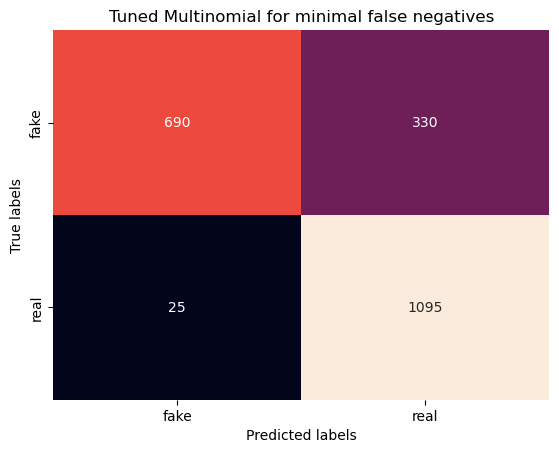

In [62]:
drawConfMat(confusion_matrix(y_test, grid.predict(X_test)), "Tuned Multinomial for minimal false negatives")

#### Implementation:  Ensemble modeling with Voting Classifier
> Check to see if model accuracy can be improved by using ensemble of all the trained models

In [64]:
from sklearn.ensemble import VotingClassifier 
from sklearn.metrics import accuracy_score 

In [65]:
s = time.time()
vote = VotingClassifier(estimators = estimators, voting ='hard') 
vote.fit(X_train, y_train) 
e = time.time()

In [66]:
y_pred = vote.predict(X_test)
test_acc = vote.score(X_test, y_test)
train_acc = vote.score(X_train, y_train)
res.loc["Voting Classifier"] = [train_acc, test_acc, e-s]

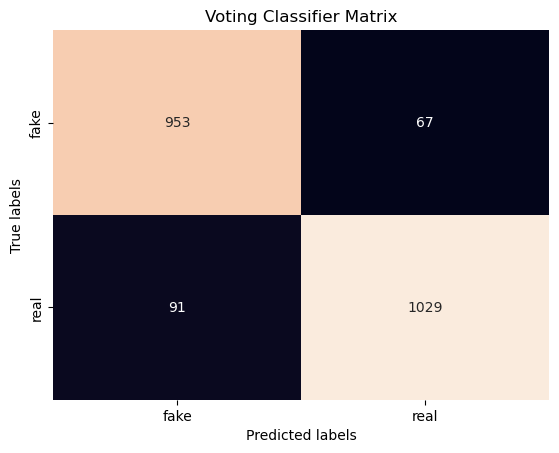

In [67]:
drawConfMat(confusion_matrix(y_test, y_pred), "Voting Classifier Matrix")

#### Results:  Summary of all models for sentiment analysis

In [69]:
print(res.sort_values('Test Accuracy', ascending=False))

                      Train Accuracy  Test Accuracy  Execution Time(s)
Voting Classifier           0.980685       0.926168           5.431845
MNB with TDIDF              0.997352       0.925234           6.763815
LR with CV                  0.987539       0.921028           8.546452
SVM with CV                 0.975078       0.913084          18.590330
SVM with TDIDF              0.940187       0.910748          64.438284
LR with TDIDF               0.950623       0.908879          22.672263
MNB with CV                 0.966978       0.908411           8.245466
Tuned MNB with TDIDF        0.891900       0.834112           3.775161
DTree with CV               0.946417       0.832243           6.050590


## Technical Report

> The dataset of 9600 samples from social media (twitter, facebook, instagram) was used to classify, if the Covid-19 related news was fake or real.

> Data engineering ( stop words removal, tweet cleanup, word vectorizing ) was done and 4 classification models ( Logistic Regression, Naive Bayes, Decision Tree and SVM) were trained.

> Grid Search was performed on each classification model, to identify the best estimator with the right hyperparameters, that increased model accuracy.

> All the models except Decision Tree had similar test and training accuracy ( 1-2% ) and execution times ( 3 seconds per fit).

> Voting Classifier model was explored to see if the majority vote would improve the accuracy or reduce mis-classification. But it did not make significant impact.

> Model accuracy and Mis-classification rate was used to identity the best (candidate) model for real world deployment

> ** Naive Bayes Classifer model ** is recommended for business due to reasons below:

    -  Had the best model test accuracy score: 92.5%
    -  Lowest Mis-classification rate of 0.07%
    -  Execution time relatively better than other models: 2 secs per fit

> ** Naive Bayes Classifier model ** hyperparameter (smoother alpha) was tuned to further reduce false negatives by 70%. This model can be deployed where stricter decision threshdold was needed.

> Next Steps

   - Naive Bayes model should be used for model training (candidate) with more data to further improve model accuracy and reduce mis-classifcation rate.

   - Advanced text processors namely: SBERT sentence transformer, Google Word2Vec can be used with additional compute resource for real world deployments
                                                                                                                    
   - Domain specific texts can be used to improve accuracy. For Covid-19 related news, model can be trained with text from CDC, Medical Journals, Peer reviewed technical papers etc.




